**Written by Paula T. Wang, October 2022 with help from Chen et al.(2022) at https://doi.org/10.3389/fnimg.2022.953215**

Git link: https://github.com/medianeuroscience/flow_replication.git

# Introduction

This notebook is the **level 2** analysis pipeline for a psychophysiological (PPI) analysis in Nipype. For a background in PPI and information about the GLM model and ROIs for this analysis, please see the notebook for the first level pipeline. 

In this notebook, we will be combining the results from multiple runs of one subject into one statistical parametric map for all nine ROIs relevant for our study. 

# Initialization

**<mark>NOTE:</mark> This notebook assumes that the following processes have already been run:**
1. Fmriprep preprocessing pipeline (~/projects/thesis/code/preprocessing/preproc.ipynb)
2. Distraction pipeline (~/projects/thesis/code/distraction_regressor/prepare_distraction.ipynb)
3. First level pipeline (~/projects/thesis/code/nipype_glm/firstlevel.ipynb)

## Docker Info

This notebook must be run within a custom-generated docker. The Dockerfile comand to replicate the analytical parameters for this analysis is below:

```
neurodocker generate docker --base ubuntu:20.04 \ 
--pkg-manager apt \ 
--install vim datalad tree \ 
--afni version=latest \ 
--ants version=2.3.1 \ 
--convert3d version=1.0.0 \ 
--dcm2niix version=latest method=source \ 
--freesurfer version=6.0.1 \ 
--copy license.txt /opt/freesurfer-6.0.1 \ 
--fsl version=6.0.4 \ 
--user=neuro \ 
--miniconda \ 
create_env=neuro \ 
conda_install="python=3.7 graphviz jupyter jupyterlab jupyter_contrib_nbextensions matplotlib nbformat nilearn numpy pandas pytest scipy seaborn sphinx sphinxcontrib-napoleon traits" \ 
pip_install="nibabel atlasreader nipype=1.6.1 neurora pybids" \ 
activate=true > Dockerfile
```

The Docker command used to run the container is below:
```
docker run -it --rm -v /home/pw/:/home/pw/ -p PORT:PORT -u pw:lab medianeuro/niflow:2.0 jupyter-lab --ip=0.0.0.0 --port=PORT
```

In [1]:
%autosave 5

Autosaving every 5 seconds


## Libraries

In [2]:
import getpass, os, stat
from nipype.pipeline import Workflow, Node
from nipype.interfaces.utility import IdentityInterface,Function
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Merge,ImageMaths,MultipleRegressDesign,FLAMEO

## Data Paths

In [3]:
base_dir = '/home/pw/projects/thesis/'
# Set the BIDS path
data_dir = '/home/pw/projects/thesis/data/'
# Set path where nipype will store stepwise results (e.g., masks)
exp_dir = '/home/pw/projects/thesis/out/'

try:
    os.mkdir(exp_dir)
except OSError as error:
    print(error)

# Grant root write access to our output files 
os.chmod(exp_dir, os.stat(exp_dir).st_mode | ((stat.S_IRWXU | stat.S_IRWXO)))

[Errno 17] File exists: '/home/pw/projects/thesis/out/'


In [4]:
print(f'Running data from {data_dir}')

Running data from /home/pw/projects/thesis/data/


# Workflow

Start workflow

In [5]:
wf_name = 'level2'

In [6]:
wf = Workflow(name=wf_name, base_dir=exp_dir)
wf.config["execution"]["crashfile_format"] = "txt"

Iterate over contrast list and roi list. We want to group the outcome by contrast and roi

Documentation: [nipype.interfaces.utility.IdentityInterface](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.utility.html#index-3)

In [7]:
contr_list = [1,2,3,4]
roi_list=['Thal','SFG','IFGs','IfGi','FFGl','FFGm','Cere','MFG','ACC']
infosource = Node(IdentityInterface(fields=["contr_id","roi_id"]),name="infosource")
infosource.iterables = [("contr_id", contr_list), ("roi_id", roi_list)]

## Select Data

Extract the relevant `nii.gz`inputs for all subjects. Here we use SelectFiles, instead of DataGrabber, because the former is more flexible with formatting syntax

Documentation: [nipype.interfaces.utility.SelectFiles](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.io.html#selectfiles)

In [8]:
templates = {
    'copes':'*/level1/*/*{roi_id}/*/*/*/*/cope{contr_id}.nii.gz',
    'varcopes':'*/level1/*/*{roi_id}/*/*/*/*/varcope{contr_id}.nii.gz',
    'masks':'data/bids/derivatives/*/func/*_desc-brain_mask.nii.gz'
}

selectfiles = Node(SelectFiles(templates),name="selectfiles")
selectfiles.inputs.base_directory = base_dir

## Post-Processing

### Merge Files

Merge registered copes, varcopes, and masks

In [9]:
copemerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="copemerge")

varcopemerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="varcopemerge")

maskmerge = Node(
    interface=Merge(dimension='t'),
    iterfield=['in_files'],
    name="maskmerge")


def sort_copes(files):
    numelements = len(files[0])
    outfiles = []
    for i in range(numelements):
        outfiles.insert(i, [])
        for j, elements in enumerate(files):
            outfiles[i].append(elements[i])
    return outfiles

### Mask Files

Create mask and then mask cope and varcopes

In [10]:
minmask = Node(
    interface=ImageMaths(op_string='-Tmin'),
    iterfield=['in_file'],
    name='minmask')

maskcope = Node(
    interface=ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskcope')

maskvarcope = Node(
    interface=ImageMaths(op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskvarcope')

## Level 2 Model 

### Contrast List

Set up second level contrasts and fixed effects

In [2]:
def get_contrasts(in_files):
    import numpy as np
    total = len(in_files)
    print(total)
    n_sub = 35
    ev_list = ['ev'+str(x) for x in range(1,n_sub+1)]
    weight_mtx = np.zeros((35,35))
    weight_mtx = weight_mtx.astype(np.float64)
    np.fill_diagonal(weight_mtx,1.)
    contr = ['','T',ev_list,list(weight_mtx[0])]
    contr_lst = np.tile(contr, (n_sub, 1))
    contr_lst = [list(x) for x in contr_lst]
    for i in range(n_sub):
        contr_lst[i][3] = list(weight_mtx[i])

    reg_dict = {k:None for k in ev_list}
    for k in reg_dict.keys():
        start_lst = [0.0] * total
        idx = ev_list.index(k)
        start_idx = idx*2
        end_idx = idx*2 + 1
        start_lst[start_idx] = 1.
        start_lst[end_idx] = 1.
        reg_dict[k] = start_lst
        
    return contr_lst, reg_dict

# contrastgen = Node(Function(input_names=['in_files'],
#                                     output_names=['contr_lst', 'reg_dict'],
#                                     function=get_contrasts),
#                       iterfield=['in_files'],
#                       name='contrastgen')



In [3]:
in_files = "/home/pw/projects/thesis/out/level1/_subject_id_005/_roi_ACC/level1estimate/mapflow/_level1estimate0/results/cope1.nii.gz"

In [4]:
get_contrasts(in_files)

121


([['',
   'T',
   ['ev1',
    'ev2',
    'ev3',
    'ev4',
    'ev5',
    'ev6',
    'ev7',
    'ev8',
    'ev9',
    'ev10',
    'ev11',
    'ev12',
    'ev13',
    'ev14',
    'ev15',
    'ev16',
    'ev17',
    'ev18',
    'ev19',
    'ev20',
    'ev21',
    'ev22',
    'ev23',
    'ev24',
    'ev25',
    'ev26',
    'ev27',
    'ev28',
    'ev29',
    'ev30',
    'ev31',
    'ev32',
    'ev33',
    'ev34',
    'ev35'],
   [1.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0]],
  ['',
   'T',
   ['ev1',
    'ev2',
    'ev3',
    'ev4',
    'ev5',
    'ev6',
    'ev7',
    'ev8',
    'ev9',
    'ev10',
    'ev11',
    'ev12',
    'ev13',
    'ev14',
    'ev15',
    'ev16',
    'ev17',
    'ev18',
    'ev19',
    'ev20',
    'ev21'

In [ ]:
(
    [
        ['','T',
         ['ev1','ev2','ev3','ev4','ev5','ev6','ev7','ev8','ev9','ev10','ev11','ev12','ev13','ev14','ev15','ev16','ev17','ev18','ev19','ev20','ev21','ev22','ev23','ev24','ev25','ev26','ev27','ev28','ev29','ev30','ev31','ev32','ev33','ev34','ev35'],
         [1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
        ],
        
        ['','T',
        ['ev1','ev2','ev3','ev4','ev5','ev6','ev7','ev8','ev9','ev10','ev11','ev12','ev13','ev14','ev15','ev16','ev17','ev18','ev19','ev20','ev21','ev22','ev23','ev24','ev25','ev26','ev27','ev28','ev29','ev30','ev31','ev32','ev33','ev34','ev35'],
         [0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
        ],
        ...,
    ],
    
    {'ev1': [1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'ev2': [0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'ev3': [0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'ev4': [0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     ...
     'ev35':...
    }
)

### Model Specification

Nipype recommands using [L2Model](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#l2model), which only works for the single subject. It takes the number of runs (copes at the first level) as input and does estimations for subject one by one.
Instead, we use [MultipleRegressDesign](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.fsl.model.html#multipleregressdesign). As it's name indicates, this one can deal with multiple predictors (subjects) at the same time.

In [12]:
level2model = Node(interface=MultipleRegressDesign(),
                      name='l2model')

## Analysis

In [ ]:
level2estimate =Node(
    interface=FLAMEO(run_mode='fe'),
    name="level2estimate",
    iterfield=['cope_file', 'var_cope_file'])

Save results data output

In [13]:
datasink = Node(DataSink(), name='sinker')
datasink.inputs.base_directory=os.path.join(exp_dir, "level2_results")

int2string = lambda x: 'contrast_'+str(x)

# Connect Workflow

In [14]:
wf.connect([
    
    (infosource, selectfiles, 
     [("contr_id","contr_id"),
      ("roi_id","roi_id")]),
    
    (selectfiles, copemerge,
     [("copes","in_files")]),
    (selectfiles, varcopemerge,
     [("varcopes","in_files")]),    
    (selectfiles, maskmerge,
     [("masks","in_files")]),
    
    (maskmerge, minmask,
     [("merged_file","in_file")]),
    (copemerge, maskcope,
     [("merged_file","in_file")]),
    (minmask, maskcope,
     [("out_file","in_file2")]),
    (varcopemerge, maskvarcope,
     [("merged_file","in_file")]),
    (minmask, maskvarcope,
     [("out_file","in_file2")]),

    (selectfiles, contrastgen,
     [("copes","in_files")]),
    (contrastgen, level2model, 
     [('contr_lst','contrasts'),
      ('reg_dict','regressors')]),
    
    (maskcope, level2estimate, 
     [('out_file', 'cope_file')]),
    (maskvarcope, level2estimate, 
     [('out_file', 'var_cope_file')]),
    (minmask, level2estimate, 
     [('out_file', 'mask_file')]),
    (level2model, level2estimate, 
     [('design_mat', 'design_file'),
      ('design_con', 't_con_file'),
      ('design_grp', 'cov_split_file')]),
    
    (infosource, datasink,
     [(('contr_id',int2string), "container")]),
    (level2estimate, datasink,
     [("stats_dir","stats_dir")]),

])

## Visualize Workflow

220826-16:26:24,715 nipype.workflow INFO:
	 Generated workflow graph: /home/pw/projects/thesis/out/level2/graph.png (graph2use=colored, simple_form=True).


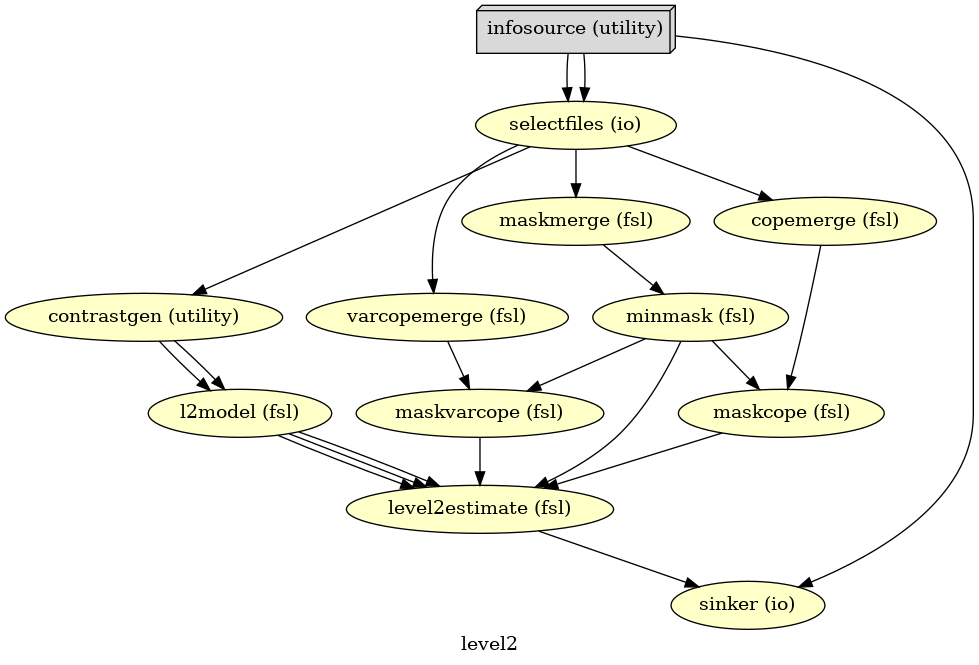

In [15]:
# Create 1st-level analysis output graph
wf.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(wf.base_dir, wf.name, 'graph.png'))

# Run

In [16]:
wf.run(plugin="MultiProc", plugin_args={"n_procs": 8})

220826-16:26:24,758 nipype.workflow INFO:
	 Workflow level2 settings: ['check', 'execution', 'logging', 'monitoring']
220826-16:26:25,284 nipype.workflow INFO:
	 Running in parallel.
220826-16:26:25,300 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 36 jobs ready. Free memory (GB): 113.29/113.29, Free processors: 8/8.
220826-16:26:25,401 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_FFGm/selectfiles".
220826-16:26:25,404 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_FFGl/selectfiles".
220826-16:26:25,407 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_IfGi/selectfiles".
220826-16:26:25,411 nipype.workflow INFO:
	 [Node] Setting-up "level2.selectfiles" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_IFGs/selectfiles".
220826-16:26:25,414 nipype

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:26:29,530 nipype.workflow INFO:
	 [Node] Setting-up "level2.copemerge" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_ACC/copemerge".
220826-16:26:29,532 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.copemerge".
220826-16:26:29,540 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.contrastgen".
220826-16:26:29,545 nipype.workflow INFO:
	 [Node] Setting-up "level2.contrastgen" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_MFG/contrastgen".
220826-16:26:29,546 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.contrastgen".
220826-16:26:29,564 nipype.workflow INFO:
	 [Job 14] Cached (level2.maskmerge).
220826-16:26:29,588 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.varcopemerge".
220826-16:26:29,613 nipype.workflow INFO:
	 [Node] Setting-up "level2.varcopemerge" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_MFG/varcopemerge".
220826-16:26:29,615 nipype.workflow INFO:
	 [Node] 

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:26:29,675 nipype.workflow INFO:
	 [Node] Finished "level2.contrastgen".
220826-16:26:29,752 nipype.workflow INFO:
	 [Node] Running "copemerge" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t cope4_merged.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_ACC/level1estimate/mapflow/_level1estimate0/results/cope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_ACC/level1estimate/mapflow/_level1estimate1/results/cope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_ACC/level1estimate/mapflow/_level1estimate2/results/cope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_006/_roi_ACC/level1estimate/mapflow/_level1estimate0/results/cope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_006/_roi_ACC/level1estimate/mapflow/_level1estimate1/results/cope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_006/_roi_ACC/level1estimate/mapflow/_level1estimate2/results/cope4.nii.gz /home/

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:27:05,562 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.varcopemerge".
220826-16:27:05,594 nipype.workflow INFO:
	 [Node] Setting-up "level2.varcopemerge" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_FFGl/varcopemerge".
220826-16:27:05,596 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.varcopemerge".
220826-16:27:05,660 nipype.workflow INFO:
	 [Node] Running "varcopemerge" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t varcope4_merged.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_FFGl/level1estimate/mapflow/_level1estimate0/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_FFGl/level1estimate/mapflow/_level1estimate1/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_FFGl/level1estimate/mapflow/_level1estimate2/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_006/_roi_FFGl/level1estimat

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:27:38,379 nipype.workflow INFO:
	 [Node] Finished "level2.contrastgen".
220826-16:27:39,367 nipype.workflow INFO:
	 [Job 67] Completed (level2.contrastgen).
220826-16:27:39,373 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 36 jobs ready. Free memory (GB): 111.89/113.29, Free processors: 1/8.
                     Currently running:
                       * level2.maskcope
                       * level2.maskvarcope
                       * level2.maskcope
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
220826-16:27:39,530 nipype.workflow INFO:
	 [Node] Finished "level2.maskcope".
220826-16:27:39,612 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.l2model".
220826-16:27:39,680 nipype.workflow INFO:
	 [Node] Setting-up "level2.l2model" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_IFGs/l2model".
220826

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:30:23,675 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.varcopemerge".
220826-16:30:23,707 nipype.workflow INFO:
	 [Node] Setting-up "level2.varcopemerge" in "/home/pw/projects/thesis/out/level2/_contr_id_4_roi_id_Thal/varcopemerge".
220826-16:30:23,709 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.varcopemerge".
220826-16:30:23,801 nipype.workflow INFO:
	 [Node] Running "varcopemerge" ("nipype.interfaces.fsl.utils.Merge"), a CommandLine Interface with command:
fslmerge -t varcope4_merged.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_Thal/level1estimate/mapflow/_level1estimate0/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_Thal/level1estimate/mapflow/_level1estimate1/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_005/_roi_Thal/level1estimate/mapflow/_level1estimate2/results/varcope4.nii.gz /home/pw/projects/thesis/out/level1/_subject_id_006/_roi_Thal/level1estimat

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:31:12,656 nipype.workflow INFO:
	 [Node] Finished "level2.contrastgen".
220826-16:31:13,577 nipype.workflow INFO:
	 [Job 122] Completed (level2.contrastgen).
220826-16:31:13,582 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 28 jobs ready. Free memory (GB): 111.89/113.29, Free processors: 1/8.
                     Currently running:
                       * level2.copemerge
                       * level2.varcopemerge
                       * level2.level2estimate
                       * level2.maskcope
                       * level2.maskvarcope
                       * level2.level2estimate
                       * level2.level2estimate
220826-16:31:13,887 nipype.workflow INFO:
	 [Node] Finished "level2.maskvarcope".
220826-16:31:13,984 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.l2model".
220826-16:31:14,52 nipype.workflow INFO:
	 [Node] Setting-up "level2.l2model" in "/home/pw/projects/thesis/out/level2/_contr_id_3_roi_id_Cere/l2model".
2208

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:34:20,301 nipype.workflow INFO:
	 [Node] Finished "level2.contrastgen".
220826-16:34:21,649 nipype.workflow INFO:
	 [Node] Finished "level2.maskcope".
220826-16:34:21,761 nipype.workflow INFO:
	 [Job 173] Completed (level2.maskcope).
220826-16:34:21,763 nipype.workflow INFO:
	 [Job 177] Completed (level2.contrastgen).
220826-16:34:21,768 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 24 jobs ready. Free memory (GB): 112.29/113.29, Free processors: 3/8.
                     Currently running:
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
220826-16:34:21,837 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.level2estimate".
220826-16:34:21,842 nipype.workflow INFO:
	 [Node] Setting-up "level2.level2estimate" in "/home/pw/projects/thesis/out/level2/_contr_id_3_roi_id_IF

/opt/miniconda-latest/envs/neuro/lib/python3.7/site-packages/numpy/lib/shape_base.py:1250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


220826-16:37:46,336 nipype.workflow INFO:
	 [Node] Finished "level2.contrastgen".
220826-16:37:47,964 nipype.workflow INFO:
	 [Job 254] Completed (level2.contrastgen).
220826-16:37:47,969 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 16 jobs ready. Free memory (GB): 111.89/113.29, Free processors: 1/8.
                     Currently running:
                       * level2.maskcope
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
                       * level2.level2estimate
220826-16:37:48,204 nipype.workflow INFO:
	 [Node] Outdated cache found for "level2.l2model".
220826-16:37:48,287 nipype.workflow INFO:
	 [Node] Setting-up "level2.l2model" in "/home/pw/projects/thesis/out/level2/_contr_id_2_roi_id_IfGi/l2model".
220826-16:37:48,289 nipype.workflow INFO:
	 [Node] Outdated cache found for